In [36]:
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [37]:
rna_df = feather.read_feather("shared_data/rna_df.feather")
sample_info = pd.read_csv("shared_data/cancer.samples", sep="\t")[
    ["sample", "project_descriptor", "sample_type"]
]
mutation_data_df = (
    pd.read_feather("shared_data/mutation_data_df.feather")
    .drop(["Genes"], axis=1)
    
)
methylation_data_df = (
    pd.read_feather("shared_data/methylation_data_df.feather")
    .drop(["PMR_INDEX"], axis=1)
)
methylation_data_filtered_df = methylation_data_df[list(mutation_data_df.columns)].transpose()
mutation_data_df = mutation_data_df.transpose()
sample_info = sample_info.set_index("sample")

In [38]:
input_data_df = mutation_data_df.join(sample_info, how="inner")

# One-hot encode categorical variables
project_descriptor_encoded = pd.get_dummies(
    input_data_df["project_descriptor"], prefix="cancer_type"
)
sample_type_encoded = pd.get_dummies(input_data_df["sample_type"], prefix="sample_type")
data_df = pd.concat(
    [
        input_data_df.drop(["project_descriptor", "sample_type"], axis=1),
        project_descriptor_encoded,
        sample_type_encoded,
    ],
    axis=1,
)

# Scale Data
scaler = StandardScaler()
mutation_scaled = scaler.fit_transform(data_df.values.astype(np.float64))
mutation_data = mutation_scaled
meth_data = methylation_data_filtered_df.values.astype(np.float64) / 100
mutation_data = np.hstack(
    [np.ones((mutation_data.shape[0], 1)).astype(np.float64), mutation_data]
)
mutation_data = mutation_data

In [39]:
mutation_data

array([[ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ],
       [ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ],
       [ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ],
       ...,
       [ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ],
       [ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ],
       [ 1.        , -0.08216249, -0.18753374, ..., -0.44589349,
         0.45737205, -0.0560269 ]])

In [40]:
meth_data

array([[0.31657143, 0.32382716, 0.42952381, ..., 0.41647059, 0.54826923,
        0.5725    ],
       [0.44085714, 0.48641975, 0.70261905, ..., 0.49098039, 0.64798077,
        0.53333333],
       [0.47742857, 0.592375  , 0.74619048, ..., 0.50173077, 0.68867925,
        0.57666667],
       ...,
       [0.36571429, 0.254375  , 0.72595238, ..., 0.28384615, 0.33847619,
        0.57589744],
       [0.42742857, 0.38227848, 0.76595238, ..., 0.34269231, 0.65673077,
        0.49725   ],
       [0.42542857, 0.44160494, 0.56595238, ..., 0.43442308, 0.58471698,
        0.48725   ]])

In [41]:
mutation_data.shape

(2237, 19766)

In [42]:
methylation_data_df.shape

(98, 2586)

In [43]:
mutation_data_train, mutation_data_test, meth_data_train, meth_data_test = (
    train_test_split(mutation_data, meth_data, test_size=0.33, random_state=42)
)

In [44]:
regr = RandomForestRegressor(random_state=0)
regr.fit(mutation_data_train, meth_data_train)

RandomForestRegressor(random_state=0)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

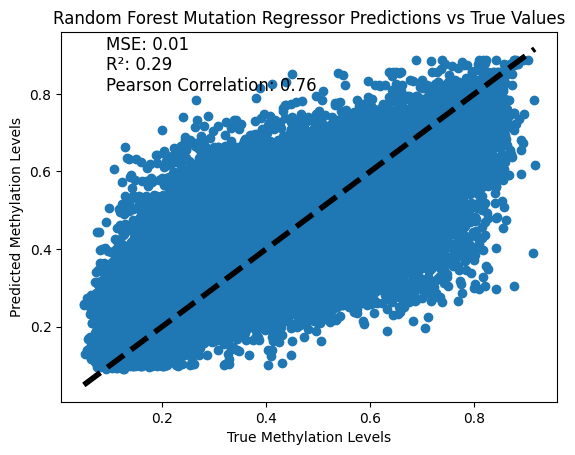

In [46]:
x_test_data = mutation_data_test
y_test_data = meth_data_test
y_pred = regr.predict(x_test_data)
mse = mean_squared_error(y_test_data, y_pred)
r2 = r2_score(y_test_data, y_pred)
pearson_corr, _ = pearsonr(y_test_data.flatten(), y_pred.flatten())

# Plot the Results
plt.scatter(y_test_data, y_pred)
plt.xlabel("True Methylation Levels")
plt.ylabel("Predicted Methylation Levels")
plt.title("Random Forest Mutation Regressor Predictions vs True Values")
plt.plot(
    [y_test_data.min(), y_test_data.max()],
    [y_test_data.min(), y_test_data.max()],
    "k--",
    lw=4,
)

x_text = y_test_data.min() + (y_test_data.max() - y_test_data.min()) * 0.05
y_text = y_pred.min() + (y_pred.max() - y_pred.min()) * 0.9

plt.text(
    x_text,
    y_text,
    f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
    fontsize=12,
)

plt.show()